In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import os
import glob
import xlsxwriter

model_results='../main_Run_63'

#Set Directory
set_model_result_dir = model_results+'/'
set_calibration_target_dir='../Calibration Targets/'
set_output_dir = '../calibration_output/'+model_results+'/02_AutoOwnership/'


if not os.path.exists(set_output_dir):
    os.makedirs(set_output_dir)

#Read calibration Target

calib_target_hhsize = pd.read_csv(os.path.join(set_calibration_target_dir, 'auto_onwership_byHHSize.csv'))

calib_target_workers = pd.read_csv(os.path.join(set_calibration_target_dir, 'auto_onwership_byNum_workers.csv'))

#Read Model Results
household_df = pd.read_csv(os.path.join(set_model_result_dir, 'householdData_3.csv'))

#Get the geocrosswalk
geo_crosswalk=pd.read_csv(os.path.join(set_model_result_dir,'geo_crosswalk.csv'))
taz_county_dict=dict(zip(geo_crosswalk['TAZ'], geo_crosswalk['COUNTYNAME']))

household_df['county_name']=household_df['taz'].map(taz_county_dict)
household_df['household_size']=np.where(household_df['size']>3,
                                        '4+',
                                        household_df['size'])
household_df['household_size']=household_df['household_size'].apply(lambda x: x+' Person HH')

household_df['num_vehicles']=np.where(household_df['autos']>3,
                                     '4+',household_df['autos'])
household_df['num_vehicles']=household_df['num_vehicles'].apply(lambda x: x+' Auto HH')

household_df['num_workers']=np.where(household_df['workers']>2,
                                        '3+',
                                        household_df['workers'])   
household_df['num_workers']=household_df['num_workers'].apply(lambda x: x.split(' ')[0]+' Worker HH')


#Need to cleanup calibration targets
calib_target_hhsize=calib_target_hhsize.rename(columns=str.lower)
calib_target_hhsize['household_size']=calib_target_hhsize['household_size'].apply(lambda x: x.split(' ')[0]+' Person HH')
calib_target_hhsize['num_vehicles']=calib_target_hhsize['num_vehicles'].apply(lambda x: x.split(' ')[0]+' Auto HH')
calib_target_hhsize['Total_Level_01_02']=calib_target_hhsize.groupby(['county_name','household_size'])['num_households'].transform(sum)
calib_target_hhsize['Target']=100*calib_target_hhsize['num_households']/calib_target_hhsize['Total_Level_01_02']
calib_target_hhsize_long=calib_target_hhsize.melt(id_vars=['county_name', 'household_size','num_vehicles'], value_vars=['Target'])
calib_target_hhsize_long=calib_target_hhsize_long.rename(columns={'county_name': 'dimension_01_value',
                                                                  'household_size': 'dimension_02_value',
                                                                  'num_vehicles': 'dimension_03_value'})
calib_target_hhsize_long['dimension_01_name'] = 'county_name'
calib_target_hhsize_long['dimension_02_name'] = 'household_size'
calib_target_hhsize_long['dimension_03_name'] = 'num_vehicles'

calib_target_workers=calib_target_workers.rename(columns=str.lower)
calib_target_workers['num_vehicles']=calib_target_workers['num_vehicles'].apply(lambda x: x.split(' ')[0]+' Auto HH')
calib_target_workers['num_workers']=calib_target_workers['num_workers'].apply(lambda x: x.split(' ')[0]+' Worker HH')
calib_target_workers['Total_Level_01_02']=calib_target_workers.groupby(['county_name','num_workers'])['num_households'].transform(sum)
calib_target_workers['Target']=100*calib_target_workers['num_households']/calib_target_workers['Total_Level_01_02']
calib_target_workers_long=calib_target_workers.melt(id_vars=['county_name', 'num_workers','num_vehicles'], value_vars=['Target'])
calib_target_workers_long=calib_target_workers_long.rename(columns={'county_name': 'dimension_01_value',
                                                                  'num_workers': 'dimension_02_value',
                                                                  'num_vehicles': 'dimension_03_value'})
calib_target_workers_long['dimension_01_name'] = 'county_name'
calib_target_workers_long['dimension_02_name'] = 'num_workers'
calib_target_workers_long['dimension_03_name'] = 'num_vehicles'


def model_summary(household_df, dimension_01_name, dimension_02_name, dimension_03_name, aggregate_column):


    household_grouped=household_df.groupby([dimension_01_name,dimension_02_name,dimension_03_name]).agg(total=(aggregate_column, 'count')).reset_index()

    household_grouped_totals=household_df.groupby([dimension_02_name,dimension_03_name]).agg(total=(aggregate_column, 'count')).reset_index()
    household_grouped_totals[dimension_01_name]='Total'

    auto_ownership_hhsize = pd.concat([household_grouped,household_grouped_totals], ignore_index=True)

    auto_ownership_hhsize['Total_Level_01_02']= auto_ownership_hhsize.groupby([dimension_01_name,dimension_02_name])['total'].transform(sum)
    auto_ownership_hhsize['Model']=100*auto_ownership_hhsize['total']/auto_ownership_hhsize['Total_Level_01_02']

    auto_ownership_hhsize_long=auto_ownership_hhsize.melt(id_vars=[dimension_01_name, dimension_02_name, dimension_03_name], value_vars=['Model'])
    
    auto_ownership_hhsize_long=auto_ownership_hhsize_long.rename(columns={dimension_01_name: 'dimension_01_value',
                                                                          dimension_02_name: 'dimension_02_value',
                                                                          dimension_03_name: 'dimension_03_value'})

    auto_ownership_hhsize_long['dimension_01_name'] = dimension_01_name
    auto_ownership_hhsize_long['dimension_02_name'] = dimension_02_name
    auto_ownership_hhsize_long['dimension_03_name'] = dimension_03_name

    return auto_ownership_hhsize_long[['dimension_01_name','dimension_01_value','dimension_02_name','dimension_02_value','dimension_03_name','dimension_03_value',
    'variable','value']]

model_summary_hhsize_df = model_summary(household_df, 'county_name', 'household_size','num_vehicles', 'hh_id')

model_summary_numworkers_df = model_summary(household_df, 'county_name', 'num_workers','num_vehicles', 'hh_id')

comparison_df = pd.concat([calib_target_hhsize_long,model_summary_hhsize_df, calib_target_workers_long,model_summary_numworkers_df], ignore_index=True)[['dimension_01_name','dimension_01_value','dimension_02_name','dimension_02_value','dimension_03_name','dimension_03_value','variable','value']]

writer = pd.ExcelWriter(os.path.join(set_output_dir,'autoOwnershipSummary.xlsx'), engine='xlsxwriter')

comparison_df_output=pd.pivot(comparison_df,
                              index=['dimension_01_name','dimension_01_value','dimension_02_name','dimension_02_value','dimension_03_name','dimension_03_value'],
                              columns='variable',values='value').reset_index()

comparison_df_output= comparison_df_output.rename(columns={'Model':model_results})

comparison_df_output = comparison_df_output[['dimension_01_name', 'dimension_01_value', 'dimension_02_name',
       'dimension_02_value', 'dimension_03_name', 'dimension_03_value',
       'Target',model_results]]

In [9]:
hhsize_df=comparison_df[(comparison_df['dimension_02_name']=='household_size')&(comparison_df['dimension_01_value']=='Total')]

hhsize_df

,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,dimension_03_name,dimension_03_value,variable,value
200,county_name,Total,household_size,1 Person HH,num_vehicles,0 Auto HH,Target,22.465264
201,county_name,Total,household_size,1 Person HH,num_vehicles,1 Auto HH,Target,63.746261
202,county_name,Total,household_size,1 Person HH,num_vehicles,2 Auto HH,Target,11.188763
203,county_name,Total,household_size,1 Person HH,num_vehicles,3 Auto HH,Target,2.008172
204,county_name,Total,household_size,1 Person HH,num_vehicles,4+ Auto HH,Target,0.591540
205,county_name,Total,household_size,2 Person HH,num_vehicles,0 Auto HH,Target,7.533427
206,county_name,Total,household_size,2 Person HH,num_vehicles,1 Auto HH,Target,26.896099
207,county_name,Total,household_size,2 Person HH,num_vehicles,2 Auto HH,Target,49.562953
208,county_name,Total,household_size,2 Person HH,num_vehicles,3 Auto HH,Target,12.229676
209,county_name,Total,household_size,2 Person HH,num_vehicles,4+ Auto HH,Target,3.777845


In [7]:
hhsize_df['dimension_02_value'].unique()

array(['1 Person HH', '2 Person HH', '3 Person HH', '4+ Person HH'],
      dtype=object)

In [56]:
network[network['FT']==2].USECLASS_AM.unique()

array([0], dtype=int64)

In [52]:
network.MANAGED.value_counts()

0    1798614
1       1505
Name: MANAGED, dtype: int64

In [43]:
network_new=pd.read_csv('../hwy/New folder/complete_network.csv')

In [46]:
nodes_old=pd.read_csv('../hwy/New folder/complete_network_nodes_old.csv')
nodes_new=pd.read_csv('../hwy/New folder/complete_network_nodes_new.csv')

In [49]:
nodes_old[~nodes_old['N'].isin(nodes_new['N'].unique())]

,N,OSM_NODE_ID,COUNTY,DRIVE_ACCESS,WALK_ACCESS,BIKE_ACCESS,RAIL_ONLY,X,Y,FAREZONE,TAP_ID


In [26]:
df=pd.DataFrame(network['NAME'].unique(), columns=['name'])
df.to_csv('list.csv', index=False)

In [39]:
juniperro_street=[#"'Junipero Serra Boulevard'",
"'Junipero Serra Freeway'",
#"'Junipero Serra Lane'",
#"'Junipero Serra Drive'",
#"'Junipero Serra Avenue'"
]

network[network['NAME'].isin(juniperro_street)].MODEL_LINK_ID.unique()
#[['USECLASS_EA','USECLASS_AM','USECLASS_PM','USECLASS_EV','USECLASS_MD']].unique()


array([1000803, 1001211, 1024199, 1017481, 1001651, 1055657, 1002797,
       1003577, 1004352, 1004496, 1004596, 1011503, 1005957, 1007407,
       1008874, 1026829, 1010109, 1016713, 1011252, 1011329, 1011944,
       1057030, 1014471, 1072572, 1013057, 1073239, 1015279, 1017658,
       1017659, 1017849, 1019759, 1021171, 1022014, 1023555, 1047922,
       1024645, 1025065, 1025447, 1026831, 1028986, 1033557, 1033612,
       1035440, 1042849, 1036058, 1038056, 1050167, 1040690, 1040906,
       1041106, 1075543, 1041731, 1062013, 1066310, 1044501, 1045063,
       1045849, 1046162, 1046550, 1046817, 1047753, 1048514, 1067394,
       1050839, 1052061, 1052284, 1052371, 1052687, 1053642, 1054215,
       1069034, 1059618, 1056949, 1058446, 1059604, 1060553, 1062299,
       1063097, 1065141, 1065903, 1069910, 1070169, 1070721, 1074375,
       1074915, 1075055, 2003290, 2010212, 2021200, 2021491, 2021506,
       2127217, 2036005, 2036925, 2039322, 2044982, 2051797, 2056054,
       2061036, 2063

In [17]:
network[network['USECLASS_AM']!=0].NAME.unique()

array(["' '", "'West Valley Freeway'", "'MacArthur Freeway'",
       "'Eastshore Freeway'"], dtype=object)

In [10]:
network.USECLASS_AM.value_counts()

0    1800002
4        115
3          2
Name: USECLASS_AM, dtype: int64

In [3]:
import pandas as pd
import numpy as np
import os
import xlsxwriter

import math 

samplesize = 100/10
model_results='main_Run_60'

#Set Directory
set_model_result_dir = '../'+model_results+'/'

geo_crosswalk=pd.read_csv(os.path.join(set_model_result_dir,'geo_crosswalk.csv'))

taz_county_dict=dict(zip(geo_crosswalk['TAZ'], geo_crosswalk['COUNTYNAME']))

indiv_trip_df = pd.read_csv(os.path.join(set_model_result_dir, 'indivTripData_1.csv'))
joint_trip_df = pd.read_csv(os.path.join(set_model_result_dir, 'jointTripData_1.csv'))
distance_skim = pd.read_csv(os.path.join(set_model_result_dir, 'da_am_skims.csv'))
distance_skim = distance_skim[(distance_skim['dist'].notnull())&(distance_skim['dist']<10000)]

trip_mode_dict={1:'Drive Alone',
                2:'Drive Alone',
                3:'Shared Ride 2',
                4:'Shared Ride 2',
                5:'Shared Ride 3+',
                6:'Shared Ride 3+',
                7:'Walk',
                8:'Bike',
                9:'Walk-Bus',
                10:'Walk-LRT',
                11:'Walk-Bus',
                12:'Walk-UR',
                13:'Walk-CR',
                14:'PNR-Bus',
                15:'PNR-LRT',
                16:'PNR-Bus',
                17:'PNR-UR',
                18:'PNR-CR',
                19:'Taxi',
                20:'TNC',
                21:'TNC-Shared'}

indiv_trip_df['trip_mode_verbose']=indiv_trip_df['trip_mode'].map(trip_mode_dict)
joint_trip_df['trip_mode_verbose']=joint_trip_df['trip_mode'].map(trip_mode_dict)

indiv_trip_df['trip_id']=indiv_trip_df.index+1
indiv_trip_df['origin_county']=indiv_trip_df['orig_taz'].map(taz_county_dict)
indiv_trip_df['destination_county'] = indiv_trip_df['dest_taz'].map(taz_county_dict)

joint_trip_df['trip_id']=joint_trip_df.index+1
joint_trip_df['origin_county']=joint_trip_df['orig_taz'].map(taz_county_dict)
joint_trip_df['destination_county'] = joint_trip_df['dest_taz'].map(taz_county_dict)

vehicle_trips=['Drive Alone','Shared Ride 2','Shared Ride 3+','Taxi','TNC','TNC-Shared']

indiv_trip_lengths=indiv_trip_df.merge(distance_skim[['origin','destination','dist']],
                                    how='left',
                                    left_on=['orig_taz','dest_taz'],
                                    right_on=['origin','destination'])[['trip_id', 'dist']]
indiv_trip_lengths_dict=dict(zip(indiv_trip_lengths['trip_id'], indiv_trip_lengths['dist']))
joint_trip_lengths=joint_trip_df.merge(distance_skim[['origin','destination','dist']],
                                    how='left',
                                    left_on=['orig_taz','dest_taz'],
                                    right_on=['origin','destination'])[['trip_id','dist']]
joint_trip_lengths_dict=dict(zip(joint_trip_lengths['trip_id'], joint_trip_lengths['dist']))


indiv_trip_df['dist']=indiv_trip_df['trip_id'].map(indiv_trip_lengths_dict)
joint_trip_df['dist']=joint_trip_df['trip_id'].map(joint_trip_lengths_dict)

indiv_vehicle_trips = indiv_trip_df[indiv_trip_df['trip_mode_verbose'].isin(vehicle_trips)]
joint_vehicle_trips = joint_trip_df[joint_trip_df['trip_mode_verbose'].isin(vehicle_trips)]

def vmt_factor(x):
    if x in ['Drive Alone','TNC']:
        return 1
    elif x in ['Shared Ride 2','Taxi']:
        return 2
    elif x in ['Shared Ride 3+','TNC-Shared']:
        return 3.25
    else:
        return 1

indiv_vehicle_trips['vmt_factor']=indiv_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)
joint_vehicle_trips['vmt_factor']=joint_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)/joint_vehicle_trips['num_participants']

indiv_vehicle_trips['vmt'] = samplesize*indiv_vehicle_trips['dist']/indiv_vehicle_trips['vmt_factor']
joint_vehicle_trips['vmt'] = samplesize*joint_vehicle_trips['dist']/joint_vehicle_trips['vmt_factor']

all_vehicle_trips = pd.concat([indiv_vehicle_trips[['trip_id','trip_mode_verbose','origin_county','destination_county','vmt']],
                               joint_vehicle_trips[['trip_id','trip_mode_verbose','origin_county','destination_county','vmt']]])


C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_1532/1442768707.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_vehicle_trips['vmt_factor']=indiv_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)
C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_1532/1442768707.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_vehicle_trips['vmt_factor']=joint_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)/joint_vehicle_trips['num_participants']
C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_1532/14

In [4]:
county_dict=['San Francisco',
             'San Mateo',
             'Santa Clara',
             'Alameda',
             'Contra Costa',
             'Solano',
             'Napa',
             'Sonoma',
             'Marin','San Joaquin']
for county in all_vehicle_trips['origin_county'].unique():

    if county not in county_dict:
        county_dict.remove(county)
county_sorter_index = dict(zip(county_dict, range(len(county_dict))))

all_vehicle_trips = pd.concat([indiv_vehicle_trips[['trip_id','trip_mode_verbose','origin_county','destination_county','vmt','dist','vmt_factor']],
                               joint_vehicle_trips[['trip_id','trip_mode_verbose','origin_county','destination_county','vmt','dist','vmt_factor']]])

def trip_factor(x):
    if x in ['Drive Alone','TNC']:
        return 1
    elif x in ['Shared Ride 2','Taxi']:
        return 0.5
    elif x in ['Shared Ride 3+','TNC-Shared']:
        return 1/3.25
    else:
        return 1

all_vehicle_trips['trip_factor']=all_vehicle_trips['trip_mode_verbose'].apply(trip_factor)
pd.crosstab(all_vehicle_trips['origin_county'],
                                    all_vehicle_trips['destination_county'], 
                                    values=all_vehicle_trips['trip_factor'], 
                                    aggfunc='sum',
                                    margins=True,
                                    margins_name='Total Trips').sort_index(key=lambda x: x.map(county_sorter_index))[county_dict].to_csv('temp.csv')

In [34]:
.head()
pd.crosstab(indiv_trip_df['origin_county'],
                                    indiv_trip_df['destination_county'], 
                                    values=all_vehicle_trips['trip_factor'], 
                                    aggfunc='sum',
                                    margins=True,
                                    margins_name='Total Trips').sort_index(key=lambda x: x.map(county_sorter_index))[county_dict]

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,...,avAvailable,sampleRate,taxiWait,singleTNCWait,sharedTNCWait,trip_mode_verbose,trip_id,origin_county,destination_county,dist
0,14,33,1,0,-1,0,othdiscr,Home,othdiscr,1,...,0,0.15,4.099678,2.725686,4.909225,Walk,1,San Francisco,San Francisco,0.98
1,14,33,1,0,-1,1,othdiscr,othdiscr,Home,7,...,0,0.15,8.961199,4.550424,6.798568,Walk,2,San Francisco,San Francisco,1.02
2,14,34,2,0,-1,0,shopping,Home,shopping,1,...,0,0.15,0.715039,0.867814,2.372647,Drive Alone,3,San Francisco,San Francisco,0.49
3,14,34,2,0,0,1,shopping,shopping,social,13,...,0,0.15,5.159480,3.168977,5.402436,Drive Alone,4,San Francisco,San Francisco,2.45
4,14,34,2,0,1,1,shopping,social,Home,40,...,0,0.15,1.968650,1.685333,3.617152,Drive Alone,5,San Francisco,San Francisco,2.10


In [28]:
pd.crosstab(all_vehicle_trips['origin_county'],
                                    all_vehicle_trips['destination_county'], 
                                    values=all_vehicle_trips['dist'], 
                                    aggfunc='mean',
                                    margins=True,
                                    margins_name='Total Trips').sort_index(key=lambda x: x.map(county_sorter_index))[county_dict]

destination_county,San Francisco,San Mateo,Santa Clara,Alameda,Contra Costa,Solano,Napa,Sonoma,Marin,San Joaquin
origin_county,,,,,,,,,,
San Francisco,3.103245,10.930065,42.671015,17.323020,26.214276,43.230499,49.173000,47.627957,16.591249,78.080625
San Mateo,11.023375,4.616794,13.562438,22.779867,38.128152,53.885125,64.125385,61.043611,28.418203,65.408182
Santa Clara,42.822015,13.566274,5.679279,20.436345,46.378392,74.055882,NaN,98.480000,62.998276,63.416980
Alameda,17.624807,22.806018,20.550482,4.896011,14.854913,35.296260,43.021590,51.961785,27.118298,35.138790
Contra Costa,26.120126,38.275157,46.111360,14.964027,5.180148,18.720391,29.609564,43.288619,20.396549,34.101085
Solano,43.201210,53.984933,73.062632,35.323112,18.831377,4.757859,13.744226,31.502004,34.254602,70.009259
Napa,48.486308,65.527333,NaN,42.926165,29.821802,13.747544,4.151245,21.021543,34.641355,NaN
Sonoma,47.805538,61.111111,98.980000,52.141644,43.834262,31.481760,20.983704,5.665815,21.902629,NaN
Marin,16.819868,28.365074,61.352500,27.557478,21.149333,34.800284,35.154390,21.953795,4.640200,86.140000


In [10]:
vehicle_trips_c_c_flow= pd.crosstab(all_vehicle_trips['origin_county'],
                                    all_vehicle_trips['destination_county'], 
                                    values=all_vehicle_trips['trip_id'], 
                                    aggfunc='count',
                                    margins=True,
                                    margins_name='Total Trips').sort_index(key=lambda x: x.map(county_sorter_index))[county_dict]

vehicle_trips_c_c_flow     

destination_county,San Francisco,San Mateo,Santa Clara,Alameda,Contra Costa,Solano,Napa,Sonoma,Marin,San Joaquin
origin_county,,,,,,,,,,
San Francisco,94148.0,16157.0,2328.0,7303.0,2643.0,298.0,47.0,172.0,4617.0,115.0
San Mateo,16035.0,135331.0,19857.0,6033.0,892.0,45.0,3.0,38.0,622.0,39.0
Santa Clara,2285.0,19933.0,497204.0,17317.0,1072.0,16.0,NaN,NaN,21.0,309.0
Alameda,7273.0,5931.0,17287.0,334578.0,26093.0,1689.0,223.0,223.0,1600.0,3926.0
Contra Costa,2742.0,889.0,1112.0,25889.0,216113.0,5785.0,552.0,205.0,2006.0,1731.0
Solano,314.0,50.0,19.0,1727.0,5701.0,87931.0,3460.0,486.0,550.0,12.0
Napa,48.0,3.0,NaN,227.0,557.0,3422.0,28730.0,1585.0,193.0,2.0
Sonoma,176.0,38.0,NaN,224.0,220.0,477.0,1579.0,125259.0,2718.0,1.0
Marin,4557.0,638.0,24.0,1633.0,1974.0,565.0,177.0,2724.0,53483.0,3.0


In [7]:
model_results='main_Run_56'

#Set Directory
set_model_result_dir = '../'+model_results+'/'

indiv_trip_df = pd.read_csv(os.path.join(set_model_result_dir, 'indivTripData_1.csv'))

indiv_trip_df

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,...,parking_taz,depart_hour,trip_mode,tour_mode,tour_category,avAvailable,sampleRate,taxiWait,singleTNCWait,sharedTNCWait
0,1296609,3541391,1,0,-1,0,shopping,Home,shopping,1,...,0,9,9,10,INDIVIDUAL_NON_MANDATORY,0,0.1,0.579747,0.756359,2.174233
1,1296609,3541391,1,0,-1,1,shopping,shopping,Home,58,...,0,12,10,10,INDIVIDUAL_NON_MANDATORY,0,0.1,2.476372,1.958809,3.979757
2,1296338,3540710,1,0,-1,0,work_high,Home,work,1,...,0,7,10,10,MANDATORY,0,0.1,9.281350,4.656323,6.898664
3,1296338,3540710,1,0,-1,1,work_high,work,Home,31,...,0,16,10,10,MANDATORY,0,0.1,1.742907,1.556038,3.438297
4,1296540,3541231,1,0,-1,0,work_med,Home,work,1,...,0,6,1,1,MANDATORY,0,0.1,4.775097,3.012194,5.231062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633569,1629684,4559496,3,0,-1,1,work_very high,work,Home,6434,...,0,18,1,3,MANDATORY,0,0.1,4.369847,2.978325,4.470462
2633570,1629684,4559497,4,0,-1,0,work_very high,Home,work,6593,...,0,10,1,1,MANDATORY,0,0.1,26.547932,17.185156,18.575071
2633571,1629684,4559497,4,0,-1,1,work_very high,work,Home,6539,...,0,19,1,1,MANDATORY,0,0.1,14.540303,6.655566,13.327696
2633572,1629684,4559498,5,0,-1,0,shopping,Home,shopping,6593,...,0,15,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,7.418705,4.980441,6.789141


In [4]:
import pandas as pd
import numpy as np
import os
import xlsxwriter

import math 

#Set Directory
model_results='main_Run_56'

#Set Directory
set_model_result_dir = '../'+model_results+'/'

geo_crosswalk=pd.read_csv(os.path.join(set_model_result_dir,'geo_crosswalk.csv'))

taz_county_dict=dict(zip(geo_crosswalk['TAZ'], geo_crosswalk['COUNTYNAME']))

indiv_trip_df = pd.read_csv(os.path.join(set_model_result_dir, 'indivTripData_1.csv'))
joint_trip_df = pd.read_csv(os.path.join(set_model_result_dir, 'jointTripData_1.csv'))
distance_skim = pd.read_csv(os.path.join(set_model_result_dir, 'da_am_skims.csv'))
distance_skim = distance_skim[(distance_skim['dist'].notnull())&(distance_skim['dist']<10000)]

trip_mode_dict={1:'Drive Alone',
                2:'Drive Alone',
                3:'Shared Ride 2',
                4:'Shared Ride 2',
                5:'Shared Ride 3+',
                6:'Shared Ride 3+',
                7:'Walk',
                8:'Bike',
                9:'Walk-Bus',
                10:'Walk-LRT',
                11:'Walk-Bus',
                12:'Walk-UR',
                13:'Walk-CR',
                14:'PNR-Bus',
                15:'PNR-LRT',
                16:'PNR-Bus',
                17:'PNR-UR',
                18:'PNR-CR',
                19:'Taxi',
                20:'TNC',
                21:'TNC-Shared'}

indiv_trip_df['trip_mode_verbose']=indiv_trip_df['trip_mode'].map(trip_mode_dict)
joint_trip_df['trip_mode_verbose']=joint_trip_df['trip_mode'].map(trip_mode_dict)

indiv_trip_df['trip_id']=indiv_trip_df.index+1
indiv_trip_df['origin_county']=indiv_trip_df['orig_taz'].map(taz_county_dict)
indiv_trip_df['destination_county'] = indiv_trip_df['dest_taz'].map(taz_county_dict)

joint_trip_df['trip_id']=joint_trip_df.index+1
joint_trip_df['origin_county']=joint_trip_df['orig_taz'].map(taz_county_dict)
joint_trip_df['destination_county'] = joint_trip_df['dest_taz'].map(taz_county_dict)

vehicle_trips=['Drive Alone','Shared Ride 2','Shared Ride 3+','Taxi','TNC','TNC-Shared']

indiv_trip_lengths=indiv_trip_df.merge(distance_skim[['origin','destination','dist']],
                                    how='left',
                                    left_on=['orig_taz','dest_taz'],
                                    right_on=['origin','destination'])[['trip_id', 'dist']]
indiv_trip_lengths_dict=dict(zip(indiv_trip_lengths['trip_id'], indiv_trip_lengths['dist']))
joint_trip_lengths=joint_trip_df.merge(distance_skim[['origin','destination','dist']],
                                    how='left',
                                    left_on=['orig_taz','dest_taz'],
                                    right_on=['origin','destination'])[['trip_id','dist']]
joint_trip_lengths_dict=dict(zip(joint_trip_lengths['trip_id'], joint_trip_lengths['dist']))


indiv_trip_df['dist']=indiv_trip_df['trip_id'].map(indiv_trip_lengths_dict)
joint_trip_df['dist']=joint_trip_df['trip_id'].map(joint_trip_lengths_dict)

indiv_vehicle_trips = indiv_trip_df[indiv_trip_df['trip_mode_verbose'].isin(vehicle_trips)]
joint_vehicle_trips = joint_trip_df[joint_trip_df['trip_mode_verbose'].isin(vehicle_trips)]

def vmt_factor(x):
    if x in ['Drive Alone','TNC']:
        return 1
    elif x in ['Shared Ride 2','Taxi']:
        return 2
    elif x in ['Shared Ride 3+','TNC-Shared']:
        return 3.25
    else:
        return 1

indiv_vehicle_trips['vmt_factor']=indiv_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)
joint_vehicle_trips['vmt_factor']=joint_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)/joint_vehicle_trips['num_participants']

indiv_vehicle_trips['vmt'] = 10*indiv_vehicle_trips['dist']/indiv_vehicle_trips['vmt_factor']
joint_vehicle_trips['vmt'] = 10*joint_vehicle_trips['dist']/joint_vehicle_trips['vmt_factor']

all_vehicle_trips = pd.concat([indiv_vehicle_trips[['trip_id','trip_mode_verbose','origin_county','destination_county','vmt']],
                               joint_vehicle_trips[['trip_id','trip_mode_verbose','origin_county','destination_county','vmt']]])

vehicle_trips_c_c_flow= pd.crosstab(all_vehicle_trips['origin_county'],
                                    all_vehicle_trips['destination_county'], 
                                    values=all_vehicle_trips['vmt'], 
                                    aggfunc='sum')

C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_32444/3641966192.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_vehicle_trips['vmt_factor']=indiv_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)
C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_32444/3641966192.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_vehicle_trips['vmt_factor']=joint_vehicle_trips['trip_mode_verbose'].apply(vmt_factor)/joint_vehicle_trips['num_participants']
C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_32444

In [5]:
indiv_trip_lengths

,trip_id,dist
0,1,1.85
1,2,1.96
2,3,1.79
3,4,1.63
4,5,18.60
...,...,...
2633569,2633570,14.68
2633570,2633571,8.87
2633571,2633572,9.57
2633572,2633573,0.60


In [1]:
#df=pd.read_excel('../calibration_output/main_Run_48/01_WorkSchoolLocation/workLocationSummary.xlsx')
import pandas as pd
import numpy as np
import os
calibration_dir = '../calibration_output/'
run_name='main_Run_48'


_df = pd.read_excel(os.path.join(calibration_dir, run_name,'01_WorkSchoolLocation','workLocationSummary.xlsx'))


In [4]:


model_results=42

calibration_dir = '../calibration_output/'
set_calibration_target_dir='../Calibration Targets/'
total_runs = model_results
tm15_reference_run = 'main_Run_TM15'
last_run_name = 'main_Run_'+str(total_runs)
    
    
comparison_df_dict={}
dist_by_hhinc={}
hue_order=['Target']
for run_number in [0, total_runs-1, total_runs]:
    if run_number == 0:
        run_name = tm15_reference_run
        hue_order.append('Travel Model 1.5')
    else:   
        run_name = 'main_Run_'+str(run_number)
    if os.path.exists(os.path.join(calibration_dir, run_name , '01_WorkSchoolLocation')):
        _df = pd.read_excel(os.path.join(calibration_dir, run_name,'01_WorkSchoolLocation','workLocationSummary.xlsx'), engine='openpyxl')
        _hhinc_df = pd.read_csv(os.path.join(calibration_dir, run_name,'01_WorkSchoolLocation','average_work_location_by_hhinc.csv'))
        _hhinc_df['Run'] = 'BCM Run_'+ run_name.split('_')[-1]
    else:
        continue
    _df_long=_df.melt(id_vars=['estimate','dimension_01_name','dimension_01_value','dimension_02_name','dimension_02_value'], 
                      value_vars=['Target',run_name])
    _df_long['variable']=np.where(_df_long['variable']==tm15_reference_run,
                                  'Travel Model 1.5', 
                                  _df_long['variable'])
    
    if run_number>0:
        _df_long = _df_long[_df_long['variable']!='Target']
        _df_long['variable']=_df_long['variable'].apply(lambda x:'BCM Run_'+ x.split('_')[-1])
        legend_entry = 'BCM Run_'+ run_name.split('_')[-1]
        hue_order.append(legend_entry)
        
    comparison_df_dict[run_name] = _df_long


BadZipFile: File is not a zip file

In [7]:
import pandas as pd
import numpy as np
import os

model_results='main_Run_20'

#Set Directory
set_model_result_dir = '../'+model_results+'/'
set_calibration_target_dir='Calibration Targets/'
set_output_dir = 'calibration_output/'+model_results+'/01_WorkSchoolLocation/'

if not os.path.exists(set_output_dir):
    os.makedirs(set_output_dir)

#Read Model Results

person_df = pd.read_csv(os.path.join(set_model_result_dir, 'wsLocResults_1.csv'))

distance_skim = pd.read_csv(os.path.join(set_model_result_dir, 'da_am_skims.csv'))
distance_skim = distance_skim[(distance_skim['dist'].notnull())&(distance_skim['dist']<10000)]

person_df_ws_loc=person_df.merge(distance_skim[['origin','destination','dist']],
                                 how='left',
                                 left_on=['HomeTAZ','WorkLocation'],
                                 right_on=['origin','destination'])

person_df_ws_loc['Intrazonal'] = np.where(person_df_ws_loc['HomeTAZ']==person_df_ws_loc['WorkLocation'],
                                         1,
                                         0)

distance_bin=range(0,111)

person_df_ws_loc['distance_bin']=pd.cut(person_df_ws_loc['dist'], distance_bin)

geo_crosswalk=pd.read_csv(os.path.join(set_model_result_dir,'geo_crosswalk.csv'))

taz_county_dict=dict(zip(geo_crosswalk['TAZ'], geo_crosswalk['COUNTYNAME']))

person_df_ws_loc['county_name']=person_df_ws_loc['HomeTAZ'].map(taz_county_dict)
person_df_ws_loc['Residency'] = person_df_ws_loc['HomeTAZ'].map(taz_county_dict)

In [10]:
def inc_group(x):
    if x<20000:
        return 'HHINC<20,000'
    elif x<50000:
        return '20,000<=HHINC<50,000'
    elif x<100000:
        return '50,000<=HHINC<100,000'
    else:
        return 'HHINC>100,000'

In [13]:
person_df_ws_loc['Income'].describe()

count    4.174780e+05
mean     1.080789e+05
std      1.023296e+05
min     -1.143500e+04
25%      4.342000e+04
50%      8.048800e+04
75%      1.362730e+05
max      1.311441e+06
Name: Income, dtype: float64

In [14]:
person_df_ws_loc['hinc_cat']=person_df_ws_loc['Income'].apply(inc_group)
person_df['hinc_cat']=person_df['Income'].apply(inc_group)

person_df.head()

,HHID,HomeTAZ,HomeSubZone,Income,PersonID,PersonNum,PersonType,PersonAge,EmploymentCategory,StudentCategory,WorkLocation,WorkSubZone,SchoolLocation,SchoolSubZone,hinc_cat
0,1294612,1,1,64694,3541485,1,Non-worker,58,Not employed,Not student,0,0,0,0,"50,000<=HHINC<100,000"
1,1294658,1,1,133474,3541556,1,Non-worker,50,Not employed,Not student,0,0,0,0,"HHINC>100,000"
2,1294658,1,1,133474,3541557,2,Non-worker,39,Not employed,Not student,0,0,0,0,"HHINC>100,000"
3,1294416,1,1,17418,3541147,1,Non-worker,57,Not employed,Not student,0,0,0,0,"HHINC<20,000"
4,1294555,1,1,71621,3541404,1,Full-time worker,49,Full-time worker,Not student,534,1,0,0,"50,000<=HHINC<100,000"


In [34]:
geo_crosswalk=pd.read_csv(os.path.join(set_model_result_dir,'geo_crosswalk.csv'))

taz_county_dict=dict(zip(geo_crosswalk['TAZ'], geo_crosswalk['COUNTYNAME']))

person_df['Origin_County']=person_df['HomeTAZ'].map(taz_county_dict)
person_df['Destination_County'] = person_df['WorkLocation'].map(taz_county_dict)

county_dict=['San Francisco',
             'San Mateo',
             'Santa Clara',
             'Alameda',
             'Contra Costa',
             'Solano',
             'Napa',
             'Sonoma',
             'Marin','San Joaquin']

county_sorter_index = dict(zip(county_dict, range(len(county_dict))))

hhinc_cc_flows={}

for hhinc in person_df.hinc_cat.unique():
    columns=county_dict.copy()
    df=person_df[person_df['hinc_cat']==hhinc]

    hhinc_cc_flow_df = pd.crosstab(df['Origin_County'],
                            df['Destination_County'], 
                            values=df['PersonID'], 
                            aggfunc='nunique', 
                            margins=True,
                            margins_name='Total Workers').reset_index()
    hhinc_cc_flow_df['HINC'] = hhinc
    columns.append('HINC')
    hhinc_cc_flow_df=hhinc_cc_flow_df.sort_values(by='Origin_County',key=lambda x: x.map(county_sorter_index)).set_index('Origin_County')[columns]

    hhinc_cc_flows[hhinc] = hhinc_cc_flow_df

hhinc_cc_flow = pd.concat(hhinc_cc_flows.values(), ignore_index=False)
hhinc_cc_flow

Destination_County,San Francisco,San Mateo,Santa Clara,Alameda,Contra Costa,Solano,Napa,Sonoma,Marin,San Joaquin,HINC
Origin_County,,,,,,,,,,,
San Francisco,4611.0,752.0,759.0,196.0,51.0,2.0,NaN,2.0,181.0,NaN,"50,000<=HHINC<100,000"
San Mateo,1104.0,2737.0,1366.0,435.0,51.0,1.0,NaN,NaN,71.0,NaN,"50,000<=HHINC<100,000"
Santa Clara,94.0,536.0,11261.0,860.0,25.0,1.0,NaN,NaN,NaN,NaN,"50,000<=HHINC<100,000"
Alameda,1232.0,466.0,1151.0,8265.0,713.0,7.0,3.0,NaN,51.0,7.0,"50,000<=HHINC<100,000"
Contra Costa,977.0,111.0,138.0,2052.0,4355.0,138.0,18.0,8.0,176.0,51.0,"50,000<=HHINC<100,000"
Solano,85.0,11.0,NaN,369.0,714.0,2074.0,197.0,44.0,99.0,NaN,"50,000<=HHINC<100,000"
Napa,11.0,2.0,1.0,47.0,110.0,141.0,871.0,140.0,42.0,NaN,"50,000<=HHINC<100,000"
Sonoma,43.0,7.0,NaN,36.0,33.0,31.0,190.0,3780.0,355.0,NaN,"50,000<=HHINC<100,000"
Marin,284.0,51.0,3.0,200.0,92.0,11.0,3.0,86.0,1171.0,NaN,"50,000<=HHINC<100,000"


In [33]:
columns=county_dict.copy()
columns.append('HINC')
columns

['San Francisco',
 'San Mateo',
 'Santa Clara',
 'Alameda',
 'Contra Costa',
 'Solano',
 'Napa',
 'Sonoma',
 'Marin',
 'San Joaquin',
 'HINC']

In [28]:
test=[1,2,2]
test.append(4)
test

[1, 2, 2, 4]

In [23]:
hhinc_cc_flows.values()

dict_values([Destination_County  San Francisco  San Mateo  Santa Clara  Alameda  \
Origin_County                                                        
San Francisco              4611.0      752.0        759.0    196.0   
San Mateo                  1104.0     2737.0       1366.0    435.0   
Santa Clara                  94.0      536.0      11261.0    860.0   
Alameda                    1232.0      466.0       1151.0   8265.0   
Contra Costa                977.0      111.0        138.0   2052.0   
Solano                       85.0       11.0          NaN    369.0   
Napa                         11.0        2.0          1.0     47.0   
Sonoma                       43.0        7.0          NaN     36.0   
Marin                       284.0       51.0          3.0    200.0   
San Joaquin                   2.0        3.0         29.0    518.0   
Total Workers              8443.0     4676.0      14708.0  12978.0   

Destination_County  Contra Costa  Solano    Napa  Sonoma   Marin  San Joaqui

In [5]:

def inc_group(x):
    if x<20000:
        return 'HHINC<20,000'
    elif x<50000:
        return '20,000<=HHINC<50,000'
    elif x<100000:
        return '50,000<=HHINC<100,000'
    else:
        return 'HHINC>100,000'

wsloc['hinc_cat']=wsloc['income'].apply(lambda x: inc_group)


,hh_id,taz,walk_subzone,income,autos,cdap_pattern,jtf_choice,jtf_pattern,size,workers,...,inmmc_rn,awf_rn,awl_rn,awtod_rn,awmc_rn,stf_rn,stl_rn,humanVehicles,autonomousVehicles,sampleRate
0,1294612,1,1,64694,1,NaN,1,none,1,0,...,0,0,0,0,0,0,0,0,0,0.05
1,1294658,1,1,133474,2,NaN,1,none,2,0,...,0,0,0,0,0,0,0,0,0,0.05
2,1294416,1,1,17418,1,NaN,1,none,1,0,...,0,0,0,0,0,0,0,0,0,0.05
3,1294555,1,1,71621,1,NaN,1,none,1,1,...,0,0,0,0,0,0,0,0,0,0.05
4,1294447,1,1,79628,3,NaN,1,none,2,0,...,0,0,0,0,0,0,0,0,0,0.05


In [170]:
trip_mode=indiv_trip_df.groupby(['dimension_01_value']).agg(total_trips=('dimension_01_value','count'))
trip_mode['Total']=trip_mode.total_trips.sum()
trip_mode['Model']=trip_mode['total_trips']/trip_mode['Total']
trip_mode=trip_mode.reset_index()[['dimension_01_value','Model']]
trip_mode

,dimension_01_value,Model
0,Bike,0.025866
1,Drive Alone,0.462998
2,PNR-Bus,0.000943
3,PNR-CR,0.001958
4,PNR-LRT,0.001736
5,PNR-UR,0.012135
6,Shared Ride 2,0.166188
7,Shared Ride 3+,0.107045
8,TNC,0.009284
9,TNC-Shared,0.004007


In [164]:
calib_target = pd.read_csv(os.path.join(set_calibration_target_dir, 'TripsbyTripMode_Targets.csv'))
calib_target['dimension_01_value']=calib_target['dimension_01_value'].map(calib_mode_dict)
calib_target_grouped=calib_target.groupby(['dimension_01_name','dimension_01_value']).agg(trips=('estimate_value','sum'))
calib_target_grouped['Total']=calib_target_grouped['trips'].sum()
calib_target_grouped['Target']=calib_target_grouped['trips']/calib_target_grouped['Total']
#calib_target=calib_target[['estimate','dimension_01_name','dimension_01_value','Target']]
calib_target_grouped=calib_target_grouped.reset_index()[['dimension_01_name','dimension_01_value','Target']]
calib_target_grouped

,dimension_01_name,dimension_01_value,Target
0,Trip Mode,Bike,0.021568
1,Trip Mode,Drive Alone,0.396672
2,Trip Mode,Other,0.013159
3,Trip Mode,PNR-Bus,0.000583
4,Trip Mode,PNR-CR,0.000618
5,Trip Mode,PNR-LRT,0.000475
6,Trip Mode,PNR-UR,0.004703
7,Trip Mode,Shared Ride 2,0.236983
8,Trip Mode,Shared Ride 3+,0.168676
9,Trip Mode,Taxi,0.001762


In [172]:
trip_mode_comparison=pd.merge(calib_target_grouped,trip_mode, on='dimension_01_value', how='outer')
trip_mode_comparison

,dimension_01_name,dimension_01_value,Target,Model
0,Trip Mode,Bike,0.021568,0.025866
1,Trip Mode,Drive Alone,0.396672,0.462998
2,Trip Mode,Other,0.013159,NaN
3,Trip Mode,PNR-Bus,0.000583,0.000943
4,Trip Mode,PNR-CR,0.000618,0.001958
5,Trip Mode,PNR-LRT,0.000475,0.001736
6,Trip Mode,PNR-UR,0.004703,0.012135
7,Trip Mode,Shared Ride 2,0.236983,0.166188
8,Trip Mode,Shared Ride 3+,0.168676,0.107045
9,Trip Mode,Taxi,0.001762,0.002105


In [154]:
tour_purpose_sorter = ['Work','School', 'University', 'Discretionary', 'Eat Out', 'Escorting', 'Maintenance',
       'Shopping', 'Social',  'At-Work']
sorter_index= dict(zip(tour_purpose_sorter, range(len(tour_purpose_sorter))))

distance_comparison_df=distance_comparison_df.sort_values(by='dimension_01_value',key=lambda x: x.map(sorter_index))

distance_comparison_df

,dimension_01_value,dimension_02_value,variable,value
1150,Work,Average Tour Distance,BCM Run_17,11.879119
745,Work,Average Tour Distance,Travel Model 1.5,11.681896
331,Work,Average Tour Distance,Target,13.000000
1071,School,Average Tour Distance,BCM Run_17,2.089525
249,School,Average Tour Distance,Target,3.320000
663,School,Average Tour Distance,Travel Model 1.5,2.532773
284,University,Average Tour Distance,Target,10.700000
1105,University,Average Tour Distance,BCM Run_17,7.393329
698,University,Average Tour Distance,Travel Model 1.5,7.217731
448,Discretionary,Average Tour Distance,Travel Model 1.5,5.248759


In [143]:
comparison_df_long=pd.melt(person_share_comp, id_vars=['dimension_01_value','upper_limit','average_distance'],
                            value_vars=['Target', model_results], var_name='Legend')

comparison_df_long['upper_limit']=comparison_df_long['upper_limit'].astype(int)
comparison_df_long=comparison_df_long.sort_values(by=['dimension_01_value','upper_limit'])
comparison_df_long['Pct']=100*comparison_df_long['value']

comparison_df_long

KeyError: "The following 'value_vars' are not present in the DataFrame: [17]"

In [121]:
calib_target_school_univ= pd.read_csv(os.path.join(set_calibration_target_dir, 'SchoolandUniversityTourTLFD_Targets.csv'))
calib_target_work = pd.read_csv(os.path.join(set_calibration_target_dir, 'WorkLocationTargets.csv'))
calib_target_work=calib_target_work[calib_target_work['estimate']=='Share of commute length by distance bin (exclude intrazonal)']
calib_target_work=calib_target_work.drop(columns='dimension_02_value')
calib_target_work=calib_target_work.rename(columns={'dimension_01_value':'dimension_02_value'})
calib_target_work['dimension_01_value']='Work'

calib_target_all=pd.concat([calib_target, calib_target_school_univ, calib_target_work], ignore_index=True)
calib_target_all


,source,estimate,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,estimate_value,average_distance,upper_limit
0,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,At-Work,Distance Bin (miles),[0-1],Share of Tours,0.435224,3.93,1.0
1,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,At-Work,Distance Bin (miles),[1-2],Share of Tours,0.125622,3.93,2.0
2,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,At-Work,Distance Bin (miles),[2-3],Share of Tours,0.112682,3.93,3.0
3,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,At-Work,Distance Bin (miles),[3-4],Share of Tours,0.066754,3.93,4.0
4,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,At-Work,Distance Bin (miles),[4-5],Share of Tours,0.068926,3.93,5.0
...,...,...,...,...,...,...,...,...,...,...
429,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[87-88],Share of Workers,0.000056,NaN,NaN
430,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[89-90],Share of Workers,0.000118,NaN,NaN
431,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[95-96],Share of Workers,0.000028,NaN,NaN
432,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[105-106],Share of Workers,0.000080,NaN,NaN


In [119]:
calib_target_school_univ.head()

,source,estimate,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,estimate_value
0,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,School,Distance Bin (miles),[0-1],Share of Tours,0.293449
1,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,School,Distance Bin (miles),[1-2],Share of Tours,0.226010
2,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,School,Distance Bin (miles),[2-3],Share of Tours,0.143807
3,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,School,Distance Bin (miles),[3-4],Share of Tours,0.087872
4,CHTS,Share of tours by tour purpose and tour distan...,Tour Purpose,School,Distance Bin (miles),[4-5],Share of Tours,0.069370


In [120]:
calib_target_work[calib_target_school_univ.columns].head()

,source,estimate,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,estimate_value
19,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[0-1],Share of Workers,0.030347
20,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[1-2],Share of Workers,0.067968
21,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[2-3],Share of Workers,0.070893
22,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[3-4],Share of Workers,0.066372
23,CHTS,Share of commute length by distance bin (exclu...,Distance Bin (miles),Work,NaN,[4-5],Share of Workers,0.055457


In [105]:
tour_length_avg =  person_df_ws_loc.groupby('Tour Purpose').agg(average_distance_model = ('dist','mean'))
tour_length_avg

,average_distance_model
Tour Purpose,
At-Work,3.697543
Discretionary,5.060536
Eat Out,6.575927
Escorting,3.753594
Maintenance,6.575137
School,2.089525
Shopping,4.746084
Social,6.485215
University,7.393329


Text(0.05, 0.95, 'Average Tour Distance = 3.9 miles')

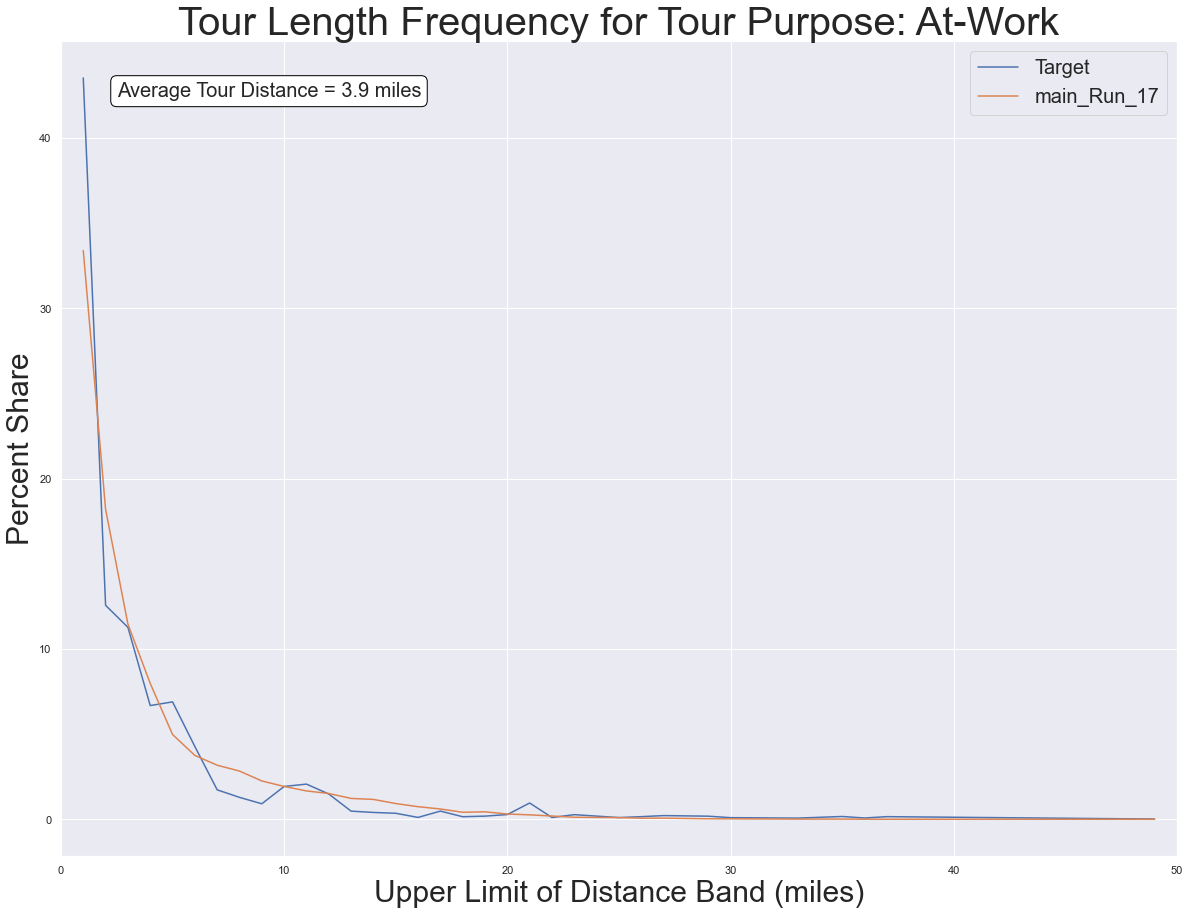

In [104]:
tour='At-Work'
props = dict(boxstyle='round', alpha=1,facecolor='white',edgecolor='black')
fig, ax = plt.subplots()

_df= comparison_df_long[comparison_df_long['dimension_01_value']==tour]
avg_dist = _df['average_distance'].mean()

ax= sns.lineplot(data=_df, 
                x='upper_limit', y='Pct', hue = 'Legend', hue_order=['Target',model_results])
ax.figure.set_size_inches(20,15)
ax.set_xlim(0,50)
ax.set_xlabel('Upper Limit of Distance Band (miles)', fontsize=30)
ax.set_ylabel('Percent Share', fontsize=30)
ax.set_title('Tour Length Frequency for Tour Purpose: '+tour, fontsize=40)
textstr = 'Average Tour Distance = %.1f miles' % (avg_dist)
plt.legend(loc='upper right', fontsize=20)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


In [77]:
writer = pd.ExcelWriter(os.path.join(set_output_dir,'TourModeChoiceSummary.xlsx'), engine='xlsxwriter')

comparison_df.to_excel(writer, sheet_name='All', startrow=1, header=False, index=False)

workbook  = writer.book
worksheet = writer.sheets['All']
# Add a header format.
header_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color': '#D7E4BC',
    'border': 1})

# Get the dimensions of the dataframe.
(max_row, max_col) = comparison_df.shape

# Make the columns wider for clarity.
worksheet.set_column(0,  max_col - 1, 12)
worksheet.autofilter(0, 0, max_row, max_col - 1)

for col_num, value in enumerate(comparison_df.columns.values):
    worksheet.write(0, col_num, value, header_format)

writer.save()

comparison_df_long=pd.melt(comparison_df, id_vars=['Tour Purpose', 'dimension_01_value','dimension_02_name','dimension_02_value','estimate_name'],
                            value_vars=['Target', 'Model'], var_name='Legend')

for tour in comparison_df_long['Tour Purpose'].unique():

    _df = comparison_df_long[(comparison_df_long['Tour Purpose']==tour)]
    _df['value']=100*_df['value']
    _df['value']=_df['value'].fillna(0)

    fig, axes = plt.subplots(1,3)

    zero_auto=_df[_df['dimension_01_value']=='Zero-Auto']
    order = ['Drive Alone', 'Shared 2 Free', 'Shared 3 Free', 'Walk','Bike',
        'Walk-Transit', 'PNR-Transit','KNR-Transit','School Bus', 'Taxi',  'TNC', 'TNC-Shared' 'Other']

    sns.barplot(x='dimension_02_value', y='value', data=zero_auto, hue='Legend', ci=None,order=order, ax=axes[0])

    axes[0].figure.set_size_inches(50,10)
    axes[0].set_title('Zero-Auto Households', fontsize=25)
    axes[0].set_xlabel('Tour Mode', fontsize=15)
    axes[0].set_ylabel('Share of Tours (Percentage)', fontsize=15)
    axes[0].legend(loc='upper right')

    insufficient_auto=_df[_df['dimension_01_value']=='Insufficient']
    order = ['Drive Alone', 'Shared 2 Free', 'Shared 3 Free', 'Walk','Bike',
        'Walk-Transit', 'PNR-Transit','KNR-Transit','School Bus', 'Taxi',  'TNC', 'TNC-Shared' 'Other']

    sns.barplot(x='dimension_02_value', y='value', data=insufficient_auto, hue='Legend', ci=None,order=order, ax=axes[1])

    axes[1].figure.set_size_inches(50,10)
    axes[1].set_title('Auto Insufficient Households', fontsize=25)
    axes[1].set_xlabel('Tour Mode', fontsize=15)
    axes[1].set_ylabel('Share of Tours (Percentage)', fontsize=15)
    axes[1].legend(loc='upper right')

    sufficient_auto=_df[_df['dimension_01_value']=='Sufficient']
    order = ['Drive Alone', 'Shared 2 Free', 'Shared 3 Free', 'Walk','Bike',
        'Walk-Transit', 'PNR-Transit','KNR-Transit','School Bus', 'Taxi',  'TNC', 'TNC-Shared' 'Other']

    sns.barplot(x='dimension_02_value', y='value', data=sufficient_auto, hue='Legend', ci=None,order=order, ax=axes[2])

    axes[2].figure.set_size_inches(50,10)
    axes[2].set_title('Auto Sufficient Households', fontsize=25)
    axes[2].set_xlabel('Tour Mode', fontsize=15)
    axes[2].set_ylabel('Share of Tours (Percentage)', fontsize=15)
    axes[2].legend(loc='upper right')

    fig.suptitle('Tour Mode Choice by Household Auto Sufficiency for '+tour.split(' ')[0]+' Tours', fontsize=40)
    fig.savefig(os.path.join(set_output_dir, 'Tour Mode Choice by Household Auto Sufficiency for '+tour.split(' ')[0]+' Tours'+'.png'),bbox_inches='tight')

,Tour Purpose,dimension_01_value,dimension_02_name,dimension_02_value,Legend,value
0,At-Work tours,All Persons,Departure Time-of-day Category,10:00 am,Target,0.075588
1,At-Work tours,All Persons,Departure Time-of-day Category,10:00 pm,Target,0.000152
2,At-Work tours,All Persons,Departure Time-of-day Category,11:00 am,Target,0.173970
3,At-Work tours,All Persons,Departure Time-of-day Category,12:00 pm,Target,0.282803
4,At-Work tours,All Persons,Departure Time-of-day Category,1:00 pm,Target,0.161519
...,...,...,...,...,...,...
12172,Social tours,All Persons,Duration in Hours,17,BCM Run_17,0.005993
12173,Social tours,All Persons,Duration in Hours,18,BCM Run_17,0.001712
12174,Social tours,All Persons,Duration in Hours,19,BCM Run_17,0.000922
12175,University tours,All Persons,Duration in Hours,1,BCM Run_17,0.190291


C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_621892/43522922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['value']=100*_df['value']


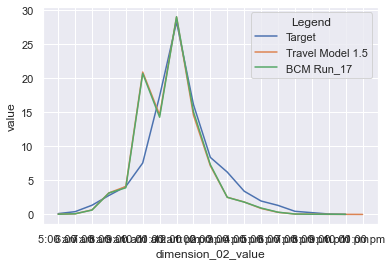

In [82]:
tour='At-Work tours'
_arrival_df=arrival_long[(arrival_long['Tour Purpose']==tour)]
_df = departure_long[(departure_long['Tour Purpose']==tour)]
max_share_arrival = int(100* _arrival_df.value.max())
max_share_departure = int(100* _df.value.max())
_df['value']=100*_df['value']

tp_available = _df.dimension_02_value.unique()

unavailable_tp=[]

for tp in sorter:
    if tp not in tp_available:
            unavailable_tp.append(tp)
unavailable_tp_df=pd.DataFrame(unavailable_tp, columns=['dimension_02_value'])
unavailable_tp_df['value']=0
unavailable_tp_df['Legend']='Model'
_df_all = pd.concat([_df, unavailable_tp_df], ignore_index=True)
_df_all=_df_all.sort_values(by='dimension_02_value',key=lambda x: x.map(sorterIndex))
# _df_all['value']=_df_all['value'].fillna(0)

fig, ax = plt.subplots()
ax=sns.lineplot(data=_df_all,
                x='dimension_02_value',
                y='value',
                hue='Legend',
                hue_order=hue_order)

In [25]:
departure_long['Tour Purpose'].unique()

array(['At-Work tours', 'Discretionary tours', 'Eat Out tours',
       'Escorting tours', 'Maintenance tours', 'School tours',
       'Shopping tours', 'Social tours', 'University tours', 'Work tours'],
      dtype=object)

In [19]:
calib_target_all[calib_target_all['Tour Purpose'].isin(['At-Work tours','Work-Related tours'])]

,source,estimate,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,estimate_value,Tour Purpose,number_of_tours,Total
630,CHTS,Share of Work-Related tours by person type and...,Person Type,Full-Time Worker,Duration in Hours,1,Share of Tours,0.163035,Work-Related tours,NaN,NaN
631,CHTS,Share of Work-Related tours by person type and...,Person Type,Full-Time Worker,Duration in Hours,2,Share of Tours,0.387148,Work-Related tours,NaN,NaN
632,CHTS,Share of Work-Related tours by person type and...,Person Type,Full-Time Worker,Duration in Hours,3,Share of Tours,0.273658,Work-Related tours,NaN,NaN
633,CHTS,Share of Work-Related tours by person type and...,Person Type,Full-Time Worker,Duration in Hours,4,Share of Tours,0.090279,Work-Related tours,NaN,NaN
634,CHTS,Share of Work-Related tours by person type and...,Person Type,Full-Time Worker,Duration in Hours,5,Share of Tours,0.066193,Work-Related tours,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2527,NaN,Number of At-Work tours by tour purpose and ar...,NaN,All Persons,Arrival Time-of-day Category,7:00 pm to 8:00 pm,NaN,0.011703,At-Work tours,5714.968835,488349.81071
2528,NaN,Number of At-Work tours by tour purpose and ar...,NaN,All Persons,Arrival Time-of-day Category,8:00 am to 9:00 am,NaN,0.011476,At-Work tours,5604.189193,488349.81071
2529,NaN,Number of At-Work tours by tour purpose and ar...,NaN,All Persons,Arrival Time-of-day Category,8:00 pm to 9:00 pm,NaN,0.000937,At-Work tours,457.716839,488349.81071
2530,NaN,Number of At-Work tours by tour purpose and ar...,NaN,All Persons,Arrival Time-of-day Category,9:00 am to 10:00 am,NaN,0.023469,At-Work tours,11461.168853,488349.81071


In [18]:
calib_target_all['Tour Purpose'].unique()

array(['Discretionary tours', 'Eat Out tours', 'Escorting tours',
       'Maintenance tours', 'School tours', 'Shopping tours',
       'Social tours', 'University tours', 'Work tours',
       'Work-Related tours', 'At-Work tours'], dtype=object)

In [16]:
indiv_tour_df['tour_purpose'].unique()

array(['work_med', 'shopping', 'work_very high', 'eatout', 'othdiscr',
       'social', 'work_high', 'atwork_business', 'school_grade',
       'atwork_eat', 'escort_kids', 'othmaint', 'escort_no kids',
       'work_low', 'university', 'atwork_maint', 'school_high'],
      dtype=object)

In [15]:
model_summary_departure_df[model_summary_departure_df['Tour Purpose']=='At-Work tours']

,Tour Purpose,dimension_01_value,dimension_02_value,total,Total_Level_01_02,Model


In [63]:
departure_target


,source,estimate,Tour Purpose,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,Target
0,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,10:00 am,Share of Tours,0.013956
1,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,2:00 pm,Share of Tours,0.015221
2,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,3:00 pm,Share of Tours,0.176082
3,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,4:00 pm,Share of Tours,0.090944
4,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,5:00 am,Share of Tours,0.115198
...,...,...,...,...,...,...,...,...,...
1813,CHTS,Share of Work-Related tours by person type and...,Work-Related tours,Person Type,Part-Time Worker,Departure Time-of-day Category,6:00 am,Share of Tours,0.007426
1814,CHTS,Share of Work-Related tours by person type and...,Work-Related tours,Person Type,Part-Time Worker,Departure Time-of-day Category,8:00 am,Share of Tours,0.009036
1815,CHTS,Share of Work-Related tours by person type and...,Work-Related tours,Person Type,Part-Time Worker,Departure Time-of-day Category,9:00 am,Share of Tours,0.055799
1816,CHTS,Share of Work-Related tours by person type and...,Work-Related tours,Person Type,University Student,Departure Time-of-day Category,11:00 am,Share of Tours,0.121424


In [73]:
departure_target.head()

,source,estimate,Tour Purpose,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,Target
0,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,10:00 am,Share of Tours,0.013956
1,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,2:00 pm,Share of Tours,0.015221
2,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,3:00 pm,Share of Tours,0.176082
3,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,4:00 pm,Share of Tours,0.090944
4,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,5:00 am,Share of Tours,0.115198


In [68]:
comparison_df[comparison_df['dimension_01_value']=='Full-Time Worker']

,dimension_01_value,dimension_02_name,dimension_02_value,variable,value
5,Full-Time Worker,School,1,Target,0.006224
6,Full-Time Worker,Work,1,Target,0.926315
7,Full-Time Worker,Work,2,Target,0.060302
8,Full-Time Worker,Work and School,0,Target,0.007159
27,Full-Time Worker,School,1,Travel Model 1.5,NaN
28,Full-Time Worker,Work,1,Travel Model 1.5,0.950260
29,Full-Time Worker,Work,2,Travel Model 1.5,0.049740
30,Full-Time Worker,Work and School,0,Travel Model 1.5,NaN
49,Full-Time Worker,School,1,BCM Run_16,NaN
50,Full-Time Worker,Work,1,BCM Run_16,0.948246


In [51]:
def create_comparison_df(person_df_ws_loc, calib_target, dimension_list, aggregate_column):

    grouped_dimension_01_all=person_df_ws_loc.groupby(dimension_list).agg(Model=(aggregate_column,'mean')).reset_index()

    
    grouped_dimension_01_all['Target']='Mean commute length by person type'

    grouped_dimension_01_extrazonal = person_df_ws_loc[person_df_ws_loc['Intrazonal']!=1].groupby(dimension_list).agg(Model=(aggregate_column,'mean')).reset_index()
    grouped_dimension_01_extrazonal['Target']='Mean commute length by person type (exclude intrazonal)'

    if dimension_list == 'PersonType':
        grouped_dimension_01_all['Target']='Mean commute length by person type'
        grouped_dimension_01_extrazonal['Target']='Mean commute length by person type (exclude intrazonal)'
    else:
        grouped_dimension_01_all['Target']='Mean commute length by residency'
        grouped_dimension_01_extrazonal['Target']='Mean commute length by residency (exclude intrazonal)'

    grouped_model_results = pd.concat([grouped_dimension_01_all, grouped_dimension_01_extrazonal], ignore_index=True)

    if dimension_list == 'PersonType':
            grouped_model_results['dimension_01_name']='Person Type'
            grouped_model_results= grouped_model_results.rename(columns={'PersonType':'dimension_01_value'})
    else:
            grouped_model_results['dimension_01_name']='Residency'
            grouped_model_results= grouped_model_results.rename(columns={'Residency':'dimension_01_value'})

    comparison_df=pd.merge(calib_target, grouped_model_results,
                                left_on=['estimate','dimension_01_name','dimension_01_value'],
                                right_on=['Target', 'dimension_01_name','dimension_01_value'],
                                how='right')
    comparison_df=comparison_df[['Target','dimension_01_name','dimension_01_value','estimate_name','estimate_value','Model']]
    comparison_df=comparison_df.rename(columns={'Target':'estimate'})
    return comparison_df

In [52]:
# persontype_comparison_long = create_comparison_df_long(person_df_ws_loc, calib_target, 'PersonType','dist')
# persontype_comparison_long['variable']=np.where(persontype_comparison_long['variable']=='Model', model_results, persontype_comparison_long['variable'])
# residency_comparison_long = create_comparison_df_long(person_df_ws_loc, calib_target, 'Residency','dist')
# residency_comparison_long['variable']=np.where(residency_comparison_long['variable']=='Model', model_results, residency_comparison_long['variable'])

# persontype_comparison = create_comparison_df(person_df_ws_loc, calib_target, 'PersonType','dist')
residency_comparison = create_comparison_df(person_df_ws_loc, calib_target, 'Residency','dist')
residency_comparison

,estimate,dimension_01_name,dimension_01_value,estimate_name,estimate_value,Model
0,Mean commute length by residency,Residency,Alameda,NaN,NaN,11.473673
1,Mean commute length by residency,Residency,Contra Costa,NaN,NaN,15.077352
2,Mean commute length by residency,Residency,Marin,NaN,NaN,12.535260
3,Mean commute length by residency,Residency,Napa,NaN,NaN,12.257260
4,Mean commute length by residency,Residency,San Francisco,NaN,NaN,10.944900
5,Mean commute length by residency,Residency,San Joaquin,NaN,NaN,9.967565
6,Mean commute length by residency,Residency,San Mateo,NaN,NaN,12.445789
7,Mean commute length by residency,Residency,Santa Clara,NaN,NaN,11.149150
8,Mean commute length by residency,Residency,Solano,NaN,NaN,15.058404
9,Mean commute length by residency,Residency,Sonoma,NaN,NaN,10.449844


In [32]:
def create_comparison_df(person_df_ws_loc, calib_target, dimension_list, aggregate_column):

    grouped_dimension_01_all=person_df_ws_loc.groupby(dimension_list).agg(Model=(aggregate_column,'mean')).reset_index()

    
    grouped_dimension_01_all['Target']='Mean commute length by person type'

    grouped_dimension_01_extrazonal = person_df_ws_loc[person_df_ws_loc['Intrazonal']!=1].groupby(dimension_list).agg(Model=(aggregate_column,'mean')).reset_index()
    grouped_dimension_01_extrazonal['Target']='Mean commute length by person type (exclude intrazonal)'

    if dimension_list == 'PersonType':
        grouped_dimension_01_all['Target']='Mean commute length by person type'
        grouped_dimension_01_extrazonal['Target']='Mean commute length by person type (exclude intrazonal)'
    else:
        grouped_dimension_01_all['Target']='Mean commute length by residency'
        grouped_dimension_01_extrazonal['Target']='Mean commute length by residency (exclude intrazonal)'

    grouped_model_results = pd.concat([grouped_dimension_01_all, grouped_dimension_01_extrazonal], ignore_index=True)

    if dimension_list == 'PersonType':
            grouped_model_results['dimension_01_name']='Person Type'
            grouped_model_results= grouped_model_results.rename(columns={'PersonType':'dimension_01_value'})
    else:
            grouped_model_results['dimension_01_name']='Residency'
            grouped_model_results= grouped_model_results.rename(columns={'Residency':'dimension_01_value'})

    comparison_df=pd.merge(calib_target, grouped_model_results,
                                left_on=['estimate','dimension_01_name','dimension_01_value'],
                                right_on=['Target', 'dimension_01_name','dimension_01_value'],
                                how='inner')

    return comparison_df[['estimate','dimension_01_name','dimension_01_value','estimate_name','estimate_value','Model']]

In [26]:
county_dict=['San Francisco',
             'San Mateo',
             'Santa Clara',
             'Alameda',
             'Contra Costa',
             'Solano',
             'Napa',
             'Sonoma',
             'Marin',
             'San Joaquin']
sorterIndex = dict(zip(county_dict, range(len(county_dict))))

work_c_c_flow= pd.crosstab(work['Origin_County'],
                            work['Destination_County'], 
                            values=work['PersonID'], 
                            aggfunc='nunique').reset_index()
work_c_c_flow=work_c_c_flow.sort_values(by='Origin_County',key=lambda x: x.map(sorterIndex))
unique_counties = work_c_c_flow.Origin_County.unique()
absent_county = list(set(county_dict)-set(unique_counties))
absent_county

['new']

In [29]:
work_c_c_flow=work_c_c_flow.set_index('Origin_County')
work_c_c_flow

Destination_County,Alameda,Contra Costa,Marin,Napa,San Francisco,San Joaquin,San Mateo,Santa Clara,Solano,Sonoma
Origin_County,,,,,,,,,,
San Francisco,151.0,14.0,1389.0,NaN,36664.0,NaN,5216.0,5167.0,NaN,23.0
San Mateo,1035.0,50.0,458.0,NaN,10750.0,NaN,18158.0,8943.0,1.0,13.0
Santa Clara,7178.0,180.0,16.0,2.0,1927.0,9.0,4572.0,79541.0,2.0,NaN
Alameda,59392.0,6057.0,5.0,25.0,257.0,179.0,1928.0,7013.0,123.0,7.0
Contra Costa,17285.0,30572.0,19.0,167.0,43.0,769.0,251.0,894.0,1129.0,35.0
Solano,1466.0,3392.0,117.0,1665.0,21.0,NaN,6.0,13.0,12445.0,244.0
Napa,231.0,455.0,149.0,4392.0,15.0,NaN,2.0,3.0,818.0,650.0
Sonoma,38.0,65.0,1663.0,1118.0,178.0,NaN,13.0,NaN,116.0,21360.0
Marin,13.0,12.0,9059.0,35.0,2866.0,NaN,222.0,15.0,12.0,519.0


In [8]:
work_c_c_flow.sort_index(key=lambda x: x.map(sorterIndex))[county_dict]

Destination_County,San Francisco,San Mateo,Santa Clara,Alameda,Contra Costa,Solano,Napa,Sonoma,Marin,San Joaquin
Origin_County,,,,,,,,,,
San Francisco,36664.0,5216.0,5167.0,151.0,14.0,NaN,NaN,23.0,1389.0,NaN
San Mateo,10750.0,18158.0,8943.0,1035.0,50.0,1.0,NaN,13.0,458.0,NaN
Santa Clara,1927.0,4572.0,79541.0,7178.0,180.0,2.0,2.0,NaN,16.0,9.0
Alameda,257.0,1928.0,7013.0,59392.0,6057.0,123.0,25.0,7.0,5.0,179.0
Contra Costa,43.0,251.0,894.0,17285.0,30572.0,1129.0,167.0,35.0,19.0,769.0
Solano,21.0,6.0,13.0,1466.0,3392.0,12445.0,1665.0,244.0,117.0,NaN
Napa,15.0,2.0,3.0,231.0,455.0,818.0,4392.0,650.0,149.0,NaN
Sonoma,178.0,13.0,NaN,38.0,65.0,116.0,1118.0,21360.0,1663.0,NaN
Marin,2866.0,222.0,15.0,13.0,12.0,12.0,35.0,519.0,9059.0,NaN


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import os
import glob
import xlsxwriter
import argparse
import math


model_results='main_Run_16'

calibration_dir = '../calibration_output/'

#Set Directory
set_model_result_dir = '../'+model_results+'/'
set_calibration_target_dir='../Calibration Targets/'
set_output_dir = '../calibration_output/'+model_results+'/09_TripsSummary/'

if not os.path.exists(set_output_dir):
    os.makedirs(set_output_dir)


indiv_trip_df = pd.read_csv(os.path.join(set_model_result_dir, 'indivTripData_1.csv'))
calib_target = pd.read_csv(os.path.join(set_calibration_target_dir, 'TripsbyTourModeandTripMode_Targets.csv'))

def tour_purpose_category(x):
    if x in ['work_med', 'work_very high', 'work_high','work_low']:
        return 'Work'
    elif x in ['school_grade','school_high']:
        return 'School'
    elif x in ['atwork_eat','atwork_maint','atwork_business']:
        return 'At-Work'
    elif x == 'shopping':
        return 'Shopping'
    elif x in ['escort_no kids','escort_kids']:
        return 'Escorting'
    elif x=='university':
        return 'University'
    elif x=='eatout':
        return 'Eat Out'
    elif x=='social':
        return 'Social'
    elif x=='othdiscr':
        return 'Discretionary'
    elif x=='othmaint':
        return 'Maintenance'
    else:
        return None

def time_period(x):
    if x<7:
        return 'EA'
    elif x<11:
        return 'AM'
    elif x<16:
        return 'MD'
    elif x<20:
        return 'PM'
    else:
        return 'EV'

tour_mode_dict={1:'Drive Alone',
                2:'Drive Alone',
                3:'Shared 2 Free',
                4:'Shared 2 Free',
                5:'Shared 3 Free',
                6:'Shared 3 Free',
                7:'Walk',
                8:'Bike',
                9:'Walk-Transit',
                10:'Walk-Transit',
                11:'Walk-Transit',
                12:'Walk-Transit',
                13:'Walk-Transit',
                14:'PNR-Transit',
                15:'PNR-Transit',
                16:'PNR-Transit',
                17:'PNR-Transit',
                18:'PNR-Transit',
                19:'Taxi',
                20:'TNC',
                21:'TNC-Shared'}

trip_mode_dict={1:'Drive Alone',
                2:'Drive Alone',
                3:'Shared Ride 2',
                4:'Shared Ride 2',
                5:'Shared Ride 3+',
                6:'Shared Ride 3+',
                7:'Walk',
                8:'Bike',
                9:'Walk-Bus',
                10:'Walk-LRT',
                11:'Walk-Bus',
                12:'Walk-UR',
                13:'Walk-CR',
                14:'PNR-Bus',
                15:'PNR-LRT',
                16:'PNR-Bus',
                17:'PNR-UR',
                18:'PNR-CR',
                19:'Taxi',
                20:'TNC',
                21:'TNC-Shared'}

calib_mode_dict={'Auto SOV (Free)            ':'Drive Alone',
                'Auto 2 Person (Free)       ':'Shared Ride 2',
                'Auto 3+ Person (Free)      ':'Shared Ride 3+',
                'Walk':'Walk',
                'Bike/Moped':'Bike',
                'Walk-Bus':'Walk-Bus',
                'Walk-BRT/Streetcar':'Walk-Bus',
                'Walk-LRT':'Walk-LRT',
                'Walk-UR':'Walk-UR',
                'Walk-CR':'Walk-CR',
                'PNR-Bus':'PNR-Bus',
                'PNR-LRT':'PNR-LRT',
                'PNR-Bus':'PNR-Bus',
                'PNR-BRT/Streetcar':'PNR-Bus',
                'PNR-UR':'PNR-UR',
                'PNR-CR':'PNR-CR',
                'Taxi/Shuttle':'Taxi',
                'KNR-Bus':'Other',
                'KNR-LRT':'Other',
                'KNR-Bus':'Other',
                'KNR-UR':'Other',
                'KNR-CR':'Other',
                'School Bus':'Other',
                'Other':'Other',
                }


In [33]:
indiv_trip_df['dimension_01_value']=indiv_trip_df['tour_mode'].map(tour_mode_dict)
indiv_trip_df['dimension_02_value']=indiv_trip_df['trip_mode'].map(trip_mode_dict)
indiv_trip_df['TimePeriod']=indiv_trip_df['depart_hour'].apply(time_period)
indiv_trip_df['Tour Purpose']=indiv_trip_df['tour_purpose'].apply(tour_purpose_category)

In [54]:
pd.options.display.max_columns=100
indiv_trip_df.head()

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,orig_walk_segment,dest_taz,dest_walk_segment,parking_taz,depart_hour,trip_mode,tour_mode,tour_category,avAvailable,sampleRate,taxiWait,singleTNCWait,sharedTNCWait,dimension_01_value,dimension_02_value,TimePeriod,Tour Purpose
0,1295248,3435916,1,0,-1,0,work_very high,Home,work,1,1,470,1,0,6,9,9,MANDATORY,0,0.1,9.738350,4.805334,7.038114,Walk-Transit,Walk-Bus,EA,Work
1,1295248,3435916,1,0,-1,1,work_very high,work,Home,470,1,1,1,0,16,9,9,MANDATORY,0,0.1,3.357774,2.391421,4.517673,Walk-Transit,Walk-Bus,PM,Work
2,1295248,3435916,1,0,-1,0,eatout,Home,eatout,1,1,401,2,0,20,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,3.540199,2.475791,4.618291,Walk,Walk,EV,Eat Out
3,1295248,3435916,1,0,-1,1,eatout,eatout,Home,401,2,1,1,0,21,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,1.744393,1.556907,3.439517,Walk,Walk,EV,Eat Out
4,1295248,3435917,2,0,-1,0,work_very high,Home,work,1,1,93,1,0,7,9,9,MANDATORY,0,0.1,14.943071,6.361996,8.411652,Walk-Transit,Walk-Bus,AM,Work


In [55]:
distance_skim = pd.read_csv(os.path.join(set_model_result_dir, 'da_am_skims.csv'))
distance_skim = distance_skim[(distance_skim['dist'].notnull())&(distance_skim['dist']<10000)]

trip_lengths=indiv_trip_df.merge(distance_skim[['origin','destination','dist']],
                                    how='left',
                                    left_on=['orig_taz','dest_taz'],
                                    right_on=['origin','destination'])

trip_lengths.head()

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,orig_walk_segment,dest_taz,dest_walk_segment,parking_taz,depart_hour,trip_mode,tour_mode,tour_category,avAvailable,sampleRate,taxiWait,singleTNCWait,sharedTNCWait,dimension_01_value,dimension_02_value,TimePeriod,Tour Purpose,origin,destination,dist
0,1295248,3435916,1,0,-1,0,work_very high,Home,work,1,1,470,1,0,6,9,9,MANDATORY,0,0.1,9.738350,4.805334,7.038114,Walk-Transit,Walk-Bus,EA,Work,1,470,1.95
1,1295248,3435916,1,0,-1,1,work_very high,work,Home,470,1,1,1,0,16,9,9,MANDATORY,0,0.1,3.357774,2.391421,4.517673,Walk-Transit,Walk-Bus,PM,Work,470,1,2.06
2,1295248,3435916,1,0,-1,0,eatout,Home,eatout,1,1,401,2,0,20,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,3.540199,2.475791,4.618291,Walk,Walk,EV,Eat Out,1,401,0.32
3,1295248,3435916,1,0,-1,1,eatout,eatout,Home,401,2,1,1,0,21,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,1.744393,1.556907,3.439517,Walk,Walk,EV,Eat Out,401,1,0.55
4,1295248,3435917,2,0,-1,0,work_very high,Home,work,1,1,93,1,0,7,9,9,MANDATORY,0,0.1,14.943071,6.361996,8.411652,Walk-Transit,Walk-Bus,AM,Work,1,93,1.43


In [58]:
trip_lengths.head()

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,orig_walk_segment,dest_taz,dest_walk_segment,parking_taz,depart_hour,trip_mode,tour_mode,tour_category,avAvailable,sampleRate,taxiWait,singleTNCWait,sharedTNCWait,dimension_01_value,dimension_02_value,TimePeriod,Tour Purpose,origin,destination,dist
0,1295248,3435916,1,0,-1,0,work_very high,Home,work,1,1,470,1,0,6,9,9,MANDATORY,0,0.1,9.738350,4.805334,7.038114,Walk-Transit,Walk-Bus,EA,Work,1,470,1.95
1,1295248,3435916,1,0,-1,1,work_very high,work,Home,470,1,1,1,0,16,9,9,MANDATORY,0,0.1,3.357774,2.391421,4.517673,Walk-Transit,Walk-Bus,PM,Work,470,1,2.06
2,1295248,3435916,1,0,-1,0,eatout,Home,eatout,1,1,401,2,0,20,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,3.540199,2.475791,4.618291,Walk,Walk,EV,Eat Out,1,401,0.32
3,1295248,3435916,1,0,-1,1,eatout,eatout,Home,401,2,1,1,0,21,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,1.744393,1.556907,3.439517,Walk,Walk,EV,Eat Out,401,1,0.55
4,1295248,3435917,2,0,-1,0,work_very high,Home,work,1,1,93,1,0,7,9,9,MANDATORY,0,0.1,14.943071,6.361996,8.411652,Walk-Transit,Walk-Bus,AM,Work,1,93,1.43


In [48]:
df= indiv_trip_df.groupby(['TimePeriod','dimension_02_value']).agg(Trips=('dimension_02_value', 'count')).reset_index()
df.pivot(index=['TimePeriod'], columns=['dimension_02_value'], values='Trips')

dimension_02_value,Bike,Drive Alone,PNR-Bus,PNR-CR,PNR-LRT,PNR-UR,Shared Ride 2,Shared Ride 3+,TNC,TNC-Shared,Taxi,Walk,Walk-Bus,Walk-CR,Walk-LRT,Walk-UR
TimePeriod,,,,,,,,,,,,,,,,
AM,20159,313579,605,1764,1198,6268,123967,88112,6444,2826,1802,112273,15613,2023,11402,4813
EA,4132,75786,166,733,349,2092,18510,9762,1073,588,419,12117,3087,749,2704,1308
EV,7450,129127,232,412,281,2319,46402,26271,2447,990,509,37318,5511,407,2563,2035
MD,19114,349584,399,696,739,2794,130787,86424,7610,2878,1235,158553,12943,1036,9815,3567
PM,19628,359004,694,2099,1360,6471,119209,74828,7008,3130,1796,98670,17396,2317,12423,5512


In [52]:
time_period_summary_df= indiv_trip_df.groupby(['TimePeriod','dimension_02_value']).agg(Trips=('dimension_02_value', 'count')).reset_index()
time_period_summary_df_wide=time_period_summary_df.pivot(index=['TimePeriod'], columns=['dimension_02_value'], values='Trips')
time_period_summary_df_wide=time_period_summary_df_wide[['Drive Alone','Shared Ride 2','Shared Ride 3+', 
                    'Walk','Bike', 
                    'Walk-Bus', 'Walk-LRT', 'Walk-UR', 'Walk-CR',
                    'PNR-Bus','PNR-LRT',  'PNR-UR', 'PNR-CR','Taxi','TNC','TNC-Shared']]
time_period_summary_df_wide

dimension_02_value,Drive Alone,Shared Ride 2,Shared Ride 3+,Walk,Bike,Walk-Bus,Walk-LRT,Walk-UR,Walk-CR,PNR-Bus,PNR-LRT,PNR-UR,PNR-CR,Taxi,TNC,TNC-Shared
TimePeriod,,,,,,,,,,,,,,,,
AM,313579,123967,88112,112273,20159,15613,11402,4813,2023,605,1198,6268,1764,1802,6444,2826
EA,75786,18510,9762,12117,4132,3087,2704,1308,749,166,349,2092,733,419,1073,588
EV,129127,46402,26271,37318,7450,5511,2563,2035,407,232,281,2319,412,509,2447,990
MD,349584,130787,86424,158553,19114,12943,9815,3567,1036,399,739,2794,696,1235,7610,2878
PM,359004,119209,74828,98670,19628,17396,12423,5512,2317,694,1360,6471,2099,1796,7008,3130


In [59]:
pd.concat([time_period_summary_df_wide, trip_df_by_purpose_grouped_wide]).to_csv('temp.csv')

In [50]:
trip_df_by_purpose_grouped=indiv_trip_df.groupby(['Tour Purpose','dimension_02_value']).agg(Trips=('dimension_02_value', 'count')).reset_index()

trip_df_by_purpose_grouped_wide=trip_df_by_purpose_grouped.pivot(index=['Tour Purpose'], columns=['dimension_02_value'], values='Trips')
trip_df_by_purpose_grouped_wide=trip_df_by_purpose_grouped_wide[['Drive Alone','Shared Ride 2','Shared Ride 3+', 
                    'Walk','Bike', 
                    'Walk-Bus', 'Walk-LRT', 'Walk-UR', 'Walk-CR',
                    'PNR-Bus','PNR-LRT',  'PNR-UR', 'PNR-CR','Taxi','TNC','TNC-Shared']]
trip_df_by_purpose_grouped_wide

dimension_02_value,Drive Alone,Shared Ride 2,Shared Ride 3+,Walk,Bike,Walk-Bus,Walk-LRT,Walk-UR,Walk-CR,PNR-Bus,PNR-LRT,PNR-UR,PNR-CR,Taxi,TNC,TNC-Shared
Tour Purpose,,,,,,,,,,,,,,,,
At-Work,92837.0,21056.0,8670.0,67722.0,5168.0,695.0,1560.0,279.0,163.0,NaN,NaN,NaN,NaN,326.0,990.0,274.0
Discretionary,108611.0,40207.0,22365.0,59299.0,8635.0,4758.0,3544.0,1706.0,394.0,201.0,406.0,658.0,275.0,52.0,1530.0,595.0
Eat Out,41553.0,13588.0,7660.0,28175.0,3660.0,2324.0,1608.0,790.0,207.0,151.0,273.0,580.0,254.0,50.0,678.0,342.0
Escorting,54669.0,77388.0,44624.0,59613.0,4484.0,2490.0,1495.0,294.0,94.0,62.0,32.0,170.0,61.0,113.0,5122.0,1738.0
Maintenance,99604.0,29964.0,17191.0,20236.0,1806.0,2447.0,1733.0,1049.0,201.0,42.0,92.0,639.0,130.0,77.0,2219.0,847.0
School,7485.0,89324.0,119618.0,80541.0,10787.0,4248.0,882.0,287.0,93.0,72.0,17.0,127.0,56.0,477.0,1368.0,401.0
Shopping,187549.0,58001.0,32675.0,41060.0,3758.0,5689.0,3629.0,846.0,169.0,76.0,20.0,331.0,80.0,162.0,4904.0,1750.0
Social,32127.0,8980.0,5170.0,19313.0,2463.0,1419.0,1001.0,574.0,132.0,98.0,184.0,380.0,170.0,28.0,400.0,210.0
University,18663.0,13225.0,1978.0,4820.0,1519.0,5540.0,2614.0,1424.0,237.0,297.0,319.0,684.0,105.0,344.0,2821.0,818.0


In [66]:
indiv_trip_df.head()

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,orig_walk_segment,dest_taz,dest_walk_segment,parking_taz,depart_hour,trip_mode,tour_mode,tour_category,avAvailable,sampleRate,taxiWait,singleTNCWait,sharedTNCWait,dimension_01_value,dimension_02_value,TimePeriod,Tour Purpose
0,1295248,3435916,1,0,-1,0,work_very high,Home,work,1,1,470,1,0,6,9,9,MANDATORY,0,0.1,9.738350,4.805334,7.038114,Walk-Transit,Walk-Bus,EA,Work
1,1295248,3435916,1,0,-1,1,work_very high,work,Home,470,1,1,1,0,16,9,9,MANDATORY,0,0.1,3.357774,2.391421,4.517673,Walk-Transit,Walk-Bus,PM,Work
2,1295248,3435916,1,0,-1,0,eatout,Home,eatout,1,1,401,2,0,20,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,3.540199,2.475791,4.618291,Walk,Walk,EV,Eat Out
3,1295248,3435916,1,0,-1,1,eatout,eatout,Home,401,2,1,1,0,21,7,7,INDIVIDUAL_NON_MANDATORY,0,0.1,1.744393,1.556907,3.439517,Walk,Walk,EV,Eat Out
4,1295248,3435917,2,0,-1,0,work_very high,Home,work,1,1,93,1,0,7,9,9,MANDATORY,0,0.1,14.943071,6.361996,8.411652,Walk-Transit,Walk-Bus,AM,Work


In [68]:
geo_crosswalk=pd.read_csv(os.path.join(set_model_result_dir,'geo_crosswalk.csv'))

taz_county_dict=dict(zip(geo_crosswalk['TAZ'], geo_crosswalk['COUNTYNAME']))

indiv_trip_df['trip_id']=indiv_trip_df.index+1
indiv_trip_df['origin_county']=indiv_trip_df['orig_taz'].map(taz_county_dict)
indiv_trip_df['destination_county'] = indiv_trip_df['dest_taz'].map(taz_county_dict)


trip_modes=['Drive Alone','Shared Ride 2','Shared Ride 3+', 
                    'Walk','Bike', 
                    'Walk-Bus', 'Walk-LRT', 'Walk-UR', 'Walk-CR',
                    'PNR-Bus','PNR-LRT',  'PNR-UR', 'PNR-CR','Taxi','TNC','TNC-Shared']

vehicle_trips=['Drive Alone','Shared Ride 2','Shared Ride 3+', 
                    'Taxi','TNC','TNC-Shared']

trip_weight = {'Drive Alone':1,'Shared Ride 2':0.5,'Shared Ride 3+':0.3, 
                    'Taxi':1,'TNC':1,'TNC-Shared':1}  

person_trips_c_c_flow= pd.crosstab(indiv_trip_df['origin_county'],
                                    indiv_trip_df['destination_county'], 
                                    values=indiv_trip_df['trip_id'], 
                                    aggfunc='count')

vehicle_trips=indiv_trip_df[indiv_trip_df['dimension_02_value'].isin(vehicle_trips)]
vehicle_trips['trip_weight']=vehicle_trips['dimension_02_value'].map(trip_weight)

vehicle_trips_c_c_flow= pd.crosstab(vehicle_trips['origin_county'],
                            vehicle_trips['destination_county'], 
                            values=vehicle_trips['trip_weight'], 
                            aggfunc='sum')




C:\Users\USJH70~1\AppData\Local\Temp/ipykernel_5947344/1604245279.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_trips['trip_weight']=vehicle_trips['dimension_02_value'].map(trip_weight)


In [70]:
person_trips_c_c_flow

destination_county,Alameda,Contra Costa,Marin,Napa,San Francisco,San Joaquin,San Mateo,Santa Clara,Solano,Sonoma
origin_county,,,,,,,,,,
Alameda,484870.0,37632.0,30.0,224.0,669.0,1889.0,4102.0,19261.0,1590.0,47.0
Contra Costa,37603.0,283912.0,47.0,645.0,82.0,1263.0,265.0,926.0,6559.0,98.0
Marin,33.0,48.0,75086.0,170.0,5884.0,NaN,665.0,34.0,140.0,2627.0
Napa,222.0,655.0,168.0,35008.0,14.0,NaN,2.0,4.0,4230.0,1988.0
San Francisco,669.0,81.0,5883.0,15.0,243788.0,6.0,25796.0,5721.0,27.0,197.0
San Joaquin,1898.0,1268.0,NaN,NaN,4.0,186228.0,14.0,79.0,9.0,NaN
San Mateo,4112.0,278.0,667.0,2.0,25808.0,17.0,165174.0,22940.0,10.0,23.0
Santa Clara,19244.0,905.0,38.0,2.0,5702.0,88.0,22985.0,602378.0,17.0,NaN
Solano,1616.0,6517.0,135.0,4258.0,27.0,9.0,9.0,16.0,111370.0,365.0


In [69]:
vehicle_trips_c_c_flow

destination_county,Alameda,Contra Costa,Marin,Napa,San Francisco,San Joaquin,San Mateo,Santa Clara,Solano,Sonoma
origin_county,,,,,,,,,,
Alameda,292017.3,28819.7,23.9,177.9,331.1,1670.9,3411.0,16091.9,1229.7,37.7
Contra Costa,28790.6,169784.0,40.0,547.7,46.8,1092.2,213.4,792.6,5497.5,82.8
Marin,26.1,40.1,44333.3,142.0,3950.8,NaN,560.8,30.1,116.3,2248.4
Napa,174.0,551.4,148.3,20910.8,10.1,NaN,1.5,3.3,3386.3,1735.7
San Francisco,348.6,45.3,3988.7,11.5,73281.3,4.5,14331.1,3182.8,14.7,131.1
San Joaquin,1673.3,1092.1,NaN,NaN,4.0,102269.7,12.1,69.1,6.8,NaN
San Mateo,3399.9,227.7,561.5,2.0,14304.9,16.0,96310.9,17433.7,9.5,19.6
Santa Clara,16095.8,774.0,32.7,2.0,3165.4,77.4,17503.2,394264.7,14.3,NaN
Solano,1237.0,5484.8,108.2,3414.4,15.4,5.9,7.8,13.5,66928.7,314.4


In [21]:
departure_target.dimension_02_value.unique()

array(['10:00 am', '2:00 pm', '3:00 pm', '4:00 pm', '5:00 am', '5:00 pm',
       '6:00 am', '6:00 pm', '7:00 am', '7:00 pm', '8:00 am', '8:00 pm',
       '9:00 am', '9:00 pm', '10:00 pm', '11:00 am', '11:00 pm',
       '12:00 pm', '1:00 pm', '3:00 am', '4:00 am', '12:00 am', '1:00 am',
       '2:00 am'], dtype=object)

In [22]:
model_summary_departure_df_comparison

,source,estimate,Tour Purpose,dimension_01_name,dimension_01_value,dimension_02_name,dimension_02_value,estimate_name,Target,variable,Model
0,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,10:00 am,Share of Tours,0.013956,Model,0.033881
1,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,2:00 pm,Share of Tours,0.015221,Model,0.104634
2,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,3:00 pm,Share of Tours,0.176082,Model,0.084704
3,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,4:00 pm,Share of Tours,0.090944,Model,0.130045
4,CHTS,Share of Discretionary tours by person type an...,Discretionary tours,Person Type,Driving Age Student,Departure Time-of-day Category,5:00 am,Share of Tours,0.115198,Model,0.014948
...,...,...,...,...,...,...,...,...,...,...,...
1332,NaN,NaN,Work-Related tours,Person Type,All Persons,Departure Time-of-day Category,7:00 pm,Share of Tours,NaN,Model,0.000338
1333,NaN,NaN,Work-Related tours,Person Type,All Persons,Departure Time-of-day Category,8:00 am,Share of Tours,NaN,Model,0.040977
1334,NaN,NaN,Work-Related tours,Person Type,All Persons,Departure Time-of-day Category,8:00 pm,Share of Tours,NaN,Model,0.000135
1335,NaN,NaN,Work-Related tours,Person Type,All Persons,Departure Time-of-day Category,9:00 am,Share of Tours,NaN,Model,0.207812


In [7]:
comparison_df.pivot(index=['dimension_01_value','dimension_02_name','dimension_02_value'], 
                                       columns='variable', values='value')

variable                                                              BCM Run_1  \
dimension_01_value  dimension_02_name             dimension_02_value              
Driving Age Student Number of Discretionary Tasks 0                    0.648938   
                                                  1                    0.332964   
                                                  2                    0.016620   
                                                  3                    0.001477   
                    Number of Eat Out Tasks       0                    0.901570   
...                                                                         ...   
University Student  Number of Shopping Tasks      2                    0.010492   
                    Number of Social Tasks        0                    0.832497   
                                                  1                    0.162485   
                                                  2                    0.004835   
                                                  3                    0.000182   

variable                                                              BCM Run_15  \
dimension_01_value  dimension_02_name             dimension_02_value               
Driving Age Student Number of Discretionary Tasks 0                     0.645418   
                                                  1                     0.336110   
                                                  2                     0.017023   
                                                  3                     0.001449   
                    Number of Eat Out Tasks       0                     0.901666   
...                                                                          ...   
University Student  Number of Shopping Tasks      2                     0.010286   
                    Number of Social Tasks        0                     0.832332   
                                                  1                     0.162662   
                                                  2                     0.004824   
                                                  3                     0.000182   

variable                                                              BCM Run_16  \
dimension_01_value  dimension_02_name             dimension_02_value               
Driving Age Student Number of Discretionary Tasks 0                     0.638730   
                                                  1                     0.344864   
                                                  2                     0.015335   
                                                  3                     0.001070   
                    Number of Eat Out Tasks       0                     0.910128   
...                                                                          ...   
University Student  Number of Shopping Tasks      2                     0.013074   
                    Number of Social Tasks        0                     0.830854   
                                                  1                     0.164638   
                                                  2                     0.004418   
                                                  3                     0.000090   

variable                                                                Target  \
dimension_01_value  dimension_02_name             dimension_02_value             
Driving Age Student Number of Discretionary Tasks 0                   0.877406   
                                                  1                   0.116324   
                                                  2                   0.006269   
                                                  3                        NaN   
                    Number of Eat Out Tasks       0                   0.989055   
...                                                                        ...   
University Student  Number of Shopping Tasks      2                   0.001675

In [ ]:
comparison_df_wide=comparison_df.reset_index().pivot(index=['dimension_01_value','dimension_02_name','dimension_02_value'], 
                                       columns='variable', values='value').reset_index().fillna(0)